#Bien, comenzemos con esto:



In [2]:
pip install opencv-python

     |████████████████████████████████| 49.1MB 80kB/s  eta 0:00:01    |█████▎                          | 8.1MB 3.4MB/s eta 0:00:12     |████████▎                       | 12.7MB 2.6MB/s eta 0:00:14     |█████████████████▏              | 26.3MB 4.6MB/s eta 0:00:05
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import gc
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

ImportError: dlopen(/Users/enrique/opt/anaconda3/lib/python3.7/site-packages/cv2/cv2.cpython-37m-darwin.so, 2): Symbol not found: _inflateValidate
  Referenced from: /Users/enrique/opt/anaconda3/lib/python3.7/site-packages/cv2/.dylibs/libpng16.16.dylib (which was built for Mac OS X 10.13)
  Expected in: /usr/lib/libz.1.dylib
 in /Users/enrique/opt/anaconda3/lib/python3.7/site-packages/cv2/.dylibs/libpng16.16.dylib

In [ ]:
DATA_PATH = Path('../input/plant-pathology-2020-fgvc7')
IMG_PATH = DATA_PATH / 'images'
LABEL_COLS = ['healthy', 'multiple_diseases', 'rust', 'scab']

IMG_SIZE = 512
SEED = 420
N_FOLDS = 5
BS = 16
N_FOLDS = 5

ARCH = densenet121

In [8]:
#viene lo del repo de kaggle: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2


In [6]:
!pip install git+https://github.com/fastai/fastcore > /dev/null
!pip install git+https://github.com/fastai/fastai2 > /dev/null
!pip install iterative-stratification > /dev/null

  Running command git clone -q https://github.com/fastai/fastcore /private/var/folders/zx/gz80lhs51hx6hgdh6nf6l0000000gn/T/pip-req-build-yi1pt_wr
  Running command git clone -q https://github.com/fastai/fastai2 /private/var/folders/zx/gz80lhs51hx6hgdh6nf6l0000000gn/T/pip-req-build-razzf93l


In [9]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
from collections import Counter
from pathlib import Path

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from tqdm.notebook import tqdm #progress bar lib
from torchvision.models import densenet121 #
from sklearn.metrics import roc_auc_score
from torch.utils.data.sampler import WeightedRandomSampler

from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

#https://pytorch.org/docs/stable/torchvision/models.html
#https://www.kaggle.com/pytorch/densenet121 and pretrained models to save time and resources of execution
#more on dense nets https://github.com/liuzhuang13/DenseNet and in https://arxiv.org/abs/1608.06993
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
#https://link.springer.com/article/10.1023/A:1010920819831 for more on ROC Operating Characteristic curves..



In [10]:
#definiendo semilla en vez de que sea 42 jaja
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [31]:
#metiendo paths de las imágenes.. 

DATA_PATH = Path('/Users/enrique/Documents/Ironhack/datamex0320/proyecto-final/ml-foliar-tree-disease/plant-pathology-2020-fgvc7')
IMG_PATH = DATA_PATH / 'images'
LABEL_COLS = ['healthy', 'multiple_diseases', 'rust', 'scab']

IMG_SIZE = 512
SEED = 420
N_FOLDS = 5
BS = 16
N_FOLDS = 5

ARCH = densenet121

In [12]:
#inicia semilla en cuatro 20

seed_everything(SEED)

Exploratory Data Analysis

In [21]:
#dataframe de las imágenes del train..
train_df = pd.read_csv('/Users/enrique/Documents/Ironhack/datamex0320/proyecto-final/ml-foliar-tree-disease/plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('/Users/enrique/Documents/Ironhack/datamex0320/proyecto-final/ml-foliar-tree-disease/plant-pathology-2020-fgvc7/test.csv')


In [23]:
train_df.head(15)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
5,Train_5,1,0,0,0
6,Train_6,0,1,0,0
7,Train_7,0,0,0,1
8,Train_8,0,0,0,1
9,Train_9,1,0,0,0


In [ ]:
#Observación: como es el train da la proba de uno 

DataSet size 

In [24]:
(len(train_df), len(test_df)) #las muestras tienen 1822 entradas en los csv

(1821, 1821)

Label distribution

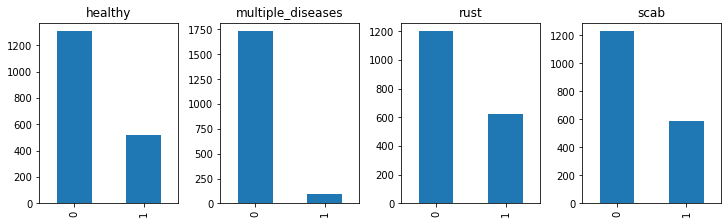

In [25]:
_, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))
for ax, column in zip(axes, LABEL_COLS):
    train_df[column].value_counts().plot.bar(title=column, ax=ax)
plt.show()

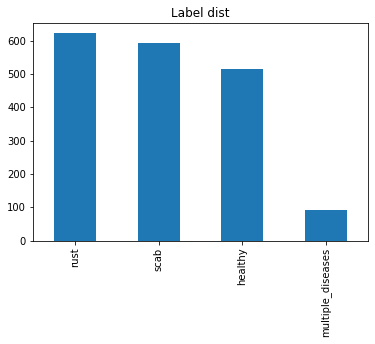

In [26]:
plt.title('Label dist')
train_df[LABEL_COLS].idxmax(axis=1).value_counts().plot.bar()

In [27]:
train_df.iloc[:,1:-1].sum(axis=1).value_counts()


1    1229
0     592
dtype: int64

In [28]:
train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum(axis=1).unique()

array([1])

del value counts y del unique vemos que tal vez se trata de una multiclase pero no clasificación multilabel.

In [32]:
#hacemos función que tome tamaños de las imágenes en la carpeta de img_path. con ello tendremos dimensiones para el modelo 
def get_size(df):
    hs, ws = [], []
    for _, row in tqdm(df.iterrows(), total=len(train_df)):
        img = Image.open(IMG_PATH/(row.image_id+'.jpg'))
        h, w = img.size
        hs.append(h)
        ws.append(w)
        
    return hs, ws


In [33]:
train_hs, train_ws = get_size(train_df)
test_hs, test_ws = get_size(test_df)

train height val counts: Counter({2048: 1819, 1365: 2})
train width val counts: Counter({1365: 1819, 2048: 2})
test height val counts: Counter({2048: 1801, 1365: 20})
test width val counts: Counter({1365: 1801, 2048: 20})


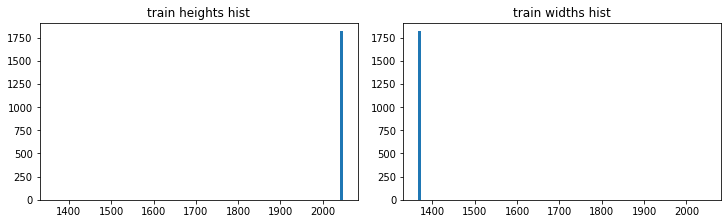

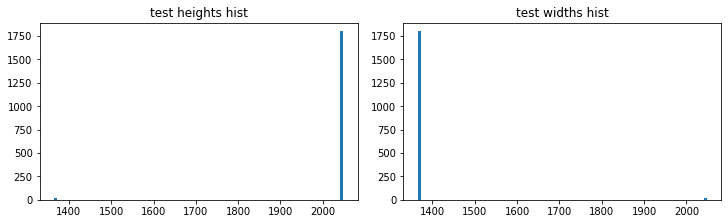

In [34]:
#se plotea para saber resolución de las imágenes del dataset de Kaggle..  
for set_label, set_size in ('train', [train_hs, train_ws]), ('test', [test_hs, test_ws]):
    print(f'{set_label} height val counts: {Counter(set_size[0])}')
    print(f'{set_label} width val counts: {Counter(set_size[1])}')

    _, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 3))
    for ax, column, vals in zip(axes, ['heights', 'widths'], set_size):
        ax.hist(vals, bins=100)
        ax.set_title(f'{set_label} {column} hist')

plt.show()

In [ ]:
#por la inspección que había hecho... y por las gráficas vemos que las dimensiones son de entre
#2048x1365 o 1365x2048 pixeles.

Ahora vemos el color. Distribución del color... por RGB

In [35]:
#histogram function for colors.. more can be consulted in the book:
#ADVANCED GUIDE TO PYTHON 3 PROGRAMMING by John hunt
#gets means for plotting in a Histogram for Red, Blue and Green spectra. 
def plot_colour_hist(df, title):
    red_values = []; green_values = []; blue_values = []; all_channels = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = np.array(Image.open(IMG_PATH/(row.image_id+'.jpg')))
        red_values.append(np.mean(img[:, :, 0]))
        green_values.append(np.mean(img[:, :, 1]))
        blue_values.append(np.mean(img[:, :, 2]))
        all_channels.append(np.mean(img))
        
    _, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(16, 3), sharey=True)
    for ax, column, vals, c in zip(
        axes,
        ['red', 'green', 'blue', 'all colours'],
        [red_values, green_values, blue_values, all_channels],
        'rgbk'
    ):
        ax.hist(vals, bins=100, color=c)
        ax.set_title(f'{column} hist')

    plt.suptitle(title)
    plt.show()

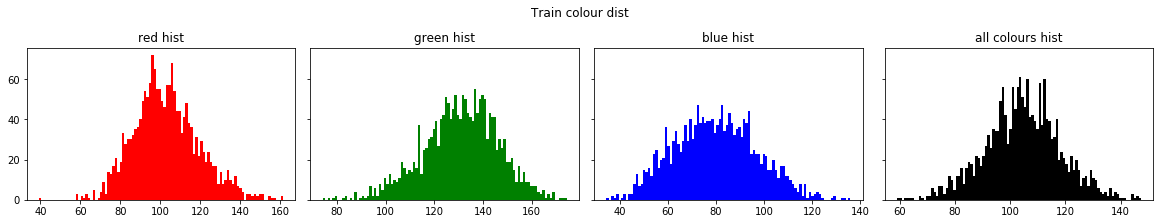

In [36]:
#we try the funtion on the hole train set
#the idea is that each bin is plotted by the ammount of RGB COLORS component for each image,interesting to see they have some sort of like normal distribution but not so much if we would look closer 
plot_colour_hist(train_df, title='Train colour dist')

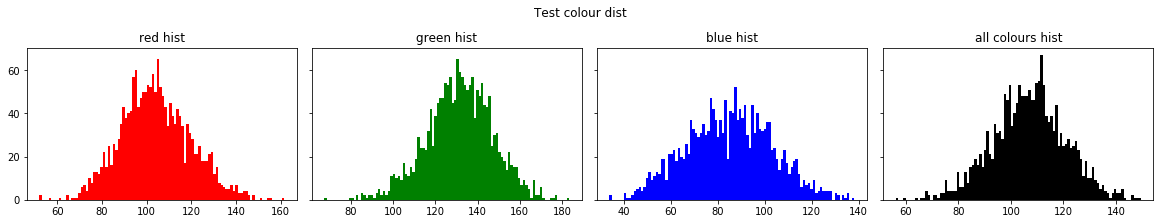

In [37]:
#then for the test dataframe
plot_colour_hist(test_df, title='Test colour dist')


Creating folds for 
Following the author,iterative stratification is used to create balanced folds.


In [38]:
#using strat_folds is for deling with multilabel data.. next would be to use data 

train_df['fold'] = -1

strat_kfold = MultilabelStratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_id.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

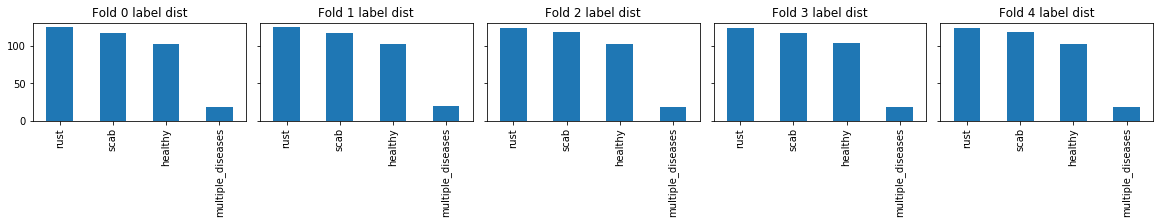

In [39]:
_, axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True, figsize=(16, 3), sharey=True)
for ax, fold in zip(axes, range(5)):
    train_df.query(f'fold == {fold}')[LABEL_COLS].idxmax(axis=1).value_counts().plot.bar(ax=ax)
    ax.set_title(f'Fold {fold} label dist') 

plt.show()

In [ ]:
#by inspection, we notice there are no  variation for diferent folds, then we shal proceede

In [40]:
train_df.to_csv('train_with_strat_folds.csv', index=False)
#saving as train_with_strat_folds with the fold stratification.
#similar as elbow stratification

#Data 

oversamplin inc..
references: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented

In [41]:
train_df['label'] = train_df[LABEL_COLS].idxmax(axis=1)

In [ ]:
#as the author suggests, there are x2 the number of multiple diseases labels as that appears to be the majorly unrepresented class.

In [42]:
#function to see how are images displayed and labeled on the sets. this helps us get them in batches
def get_data(fold):
    train_df_no_val = train_df.query(f'fold != {fold}')
    train_df_just_val = train_df.query(f'fold == {fold}')

    train_df_bal = pd.concat(
        [train_df_no_val.query('label != "multiple_diseases"'), train_df_just_val] +
        [train_df_no_val.query('label == "multiple_diseases"')] * 2
    ).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    datablock = DataBlock(
        blocks=(ImageBlock, CategoryBlock(vocab=LABEL_COLS)),
        getters=[
            ColReader('image_id', pref=IMG_PATH, suff='.jpg'),
            ColReader('label')
        ],
        splitter=IndexSplitter(train_df_bal.loc[train_df_bal.fold==fold].index),
        item_tfms=Resize(IMG_SIZE),
        batch_tfms=aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
    )
    return datablock.dataloaders(source=train_df_bal, bs=BS)

In [43]:
#dataloaders on fold 0 ... https://docs.fast.ai/vision.data.html
dls = get_data(fold=0)


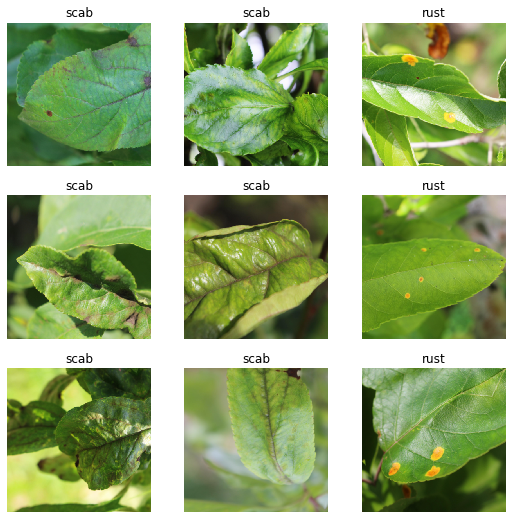

In [52]:
#we display a batch from: https://docs.fast.ai/vision.data.html everytime you execute gives you a different one
dls.show_batch()


In [ ]:
#Training of model

In [53]:
# custom functions 
def comp_metric(preds, targs, labels=range(len(LABEL_COLS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])


In [ ]:
'''traditional convolutional networks with L layers have L connections 
- one between each layer and its subsequent layer - 
dense networks have L(L+1)/2 direct connections. For each layer, 
the feature-maps of all preceding layers are used as inputs, 
and its own feature-maps are used as inputs into all subsequent layers. ''' 

In [54]:
def get_learner(fold_num, lr=1e-3):
    opt_func = partial(Adam, lr=lr, wd=0.01, eps=1e-8)

    data = get_data(fold_num)

    learn = cnn_learner(
        data, ARCH, opt_func=opt_func,
        loss_func=LabelSmoothingCrossEntropy(),
        metrics=[
            AccumMetric(healthy_roc_auc, flatten=False),
            AccumMetric(multiple_diseases_roc_auc, flatten=False),
            AccumMetric(rust_roc_auc, flatten=False),
            AccumMetric(scab_roc_auc, flatten=False),
            AccumMetric(comp_metric, flatten=False)]
        ).to_fp16()

    return learn


In [56]:
get_learner(fold_num=0).lr_find()


AttributeError: 'Learner' object has no attribute 'master_pgs'

In [48]:
    def print_metrics(val_preds, val_labels):
    comp_metric_fold = comp_metric(val_preds, val_labels)
    print(f'Comp metric: {comp_metric_fold}')
    
    healthy_roc_auc_metric = healthy_roc_auc(val_preds, val_labels)
    print(f'Healthy metric: {healthy_roc_auc_metric}')
    
    multiple_diseases_roc_auc_metric = multiple_diseases_roc_auc(val_preds, val_labels)
    print(f'Multi disease: {multiple_diseases_roc_auc_metric}')
    
    rust_roc_auc_metric = rust_roc_auc(val_preds, val_labels)
    print(f'Rust metric: {rust_roc_auc_metric}')
    
    scab_roc_auc_metric = scab_roc_auc(val_preds, val_labels)
    print(f'Scab metric: {scab_roc_auc_metric}')

NameError: name 'val_preds' is not defined

In [57]:
all_val_preds = []
all_val_labels = []
all_test_preds = []

for i in range(N_FOLDS):
    print(f'Fold {i} results')

    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(4)
    learn.unfreeze()

    learn.fit_one_cycle(8, slice(1e-5, 1e-4))
    
    learn.recorder.plot_loss()
    
    learn.save(f'model_fold_{i}')
    
    val_preds, val_labels = learn.get_preds()
    
    print_metrics(val_preds, val_labels)
    
    all_val_preds.append(val_preds)
    all_val_labels.append(val_labels)
    
    test_dl = dls.test_dl(test_df)
    test_preds, _ = learn.get_preds(dl=test_dl)
    all_test_preds.append(test_preds)
    
plt.show()


Fold 0 results


AttributeError: 'Learner' object has no attribute 'master_pgs'

In [ ]:
tras un rato de que corra...


In [58]:
print_metrics(np.concatenate(all_val_preds), np.concatenate(all_val_labels))

NameError: name 'print_metrics' is not defined

In [ ]:
Interpreting 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 10))

In [ ]:
interp.plot_confusion_matrix(normalize=True, figsize=(6, 6))


In [ ]:
Test predictions

In [59]:
test_df_output = pd.concat([test_df, pd.DataFrame(np.mean(np.stack(all_test_preds), axis=0), columns=LABEL_COLS)], axis=1)

ValueError: need at least one array to stack

In [ ]:
test_df_output.head()


In [ ]:
test_df_output.to_csv('submission.csv', index=False)

In [ ]:
!head -n 5 submission.csv